In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pytz
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.vectorized import contains
import matplotlib.patches as mpatches

In [5]:
# Define file path and region name (can be set to any region of interest)
file_path = '/g/data/w28/yk8692/nesp/testing_script'
region_name = 'Australian Capital Territory'  # Change this to any target region name
stations = pd.read_excel('/g/data/w28/yk8692/nesp/station/All_stations_information.xlsx')
# Load the Australian GCCSA shapefile
gccsa = gpd.read_file(f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")
print("Shapefile columns:", gccsa.columns.tolist())

# Filter the shapefile for the target region by name (case-insensitive match)
target_region_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)]
print(f"Number of polygons for Greater {region_name}:", len(target_region_shp))

# Convert station metadata into a GeoDataFrame.
# The 'stations' DataFrame should include 'station', 'Longitude', and 'Latitude' columns.
stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['Longitude'], stations['Latitude']),
    crs="EPSG:4326"
)

# Reproject the region shapefile to match the stations' CRS if necessary
if target_region_shp.crs != stations_gdf.crs:
    target_region_shp = target_region_shp.to_crs(stations_gdf.crs)

# Filter stations that fall within the target region
stations_in_region = stations_gdf[stations_gdf.within(target_region_shp.unary_union)]
print(f"Found {len(stations_in_region)} AWS stations within the {region_name} region.")

Shapefile columns: ['GCC_CODE21', 'GCC_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 'geometry']
Number of polygons for Greater Australian Capital Territory: 1
Found 4 AWS stations within the Australian Capital Territory region.


/jobfs/145080338.gadi-pbs/ipykernel_2938430/4264606162.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_region = stations_gdf[stations_gdf.within(target_region_shp.unary_union)]


In [3]:
import os
import pickle

# --- File and Path Setup ---
shape_path = '/g/data/w28/yk8692/nesp'
event_windows_path = f'{shape_path}/station_corrected_rv/p2_event_windows_noNAN_all_stations_{region_name}.pkl'
output_file = f'{shape_path}/figure/{region_name}_top10_all_stations_summary_global_percentile.csv'

# --- Load aggregated event window data ---
with open(event_windows_path, 'rb') as f:
    event_windows_all_stations = pickle.load(f)

# --- Collect all 1h data across all stations for threshold computation ---
all_1h_precip = []

for station_data in event_windows_all_stations.values():
    if '1h' in station_data:
        df = station_data['1h'][['Time', 'Precipitation']].copy()
        df['Precipitation'] = pd.to_numeric(df['Precipitation'], errors='coerce')
        df = df[df['Precipitation'] > 0]  # exclude zeros
        all_1h_precip.append(df['Precipitation'])

# --- Compute global thresholds ---
global_1h_series = pd.concat(all_1h_precip)
global_99p = global_1h_series.quantile(0.99)
global_999p = global_1h_series.quantile(0.999)

print(f"Global 1h 99th percentile: {global_99p:.2f} mm/hr")
print(f"Global 1h 99.9th percentile: {global_999p:.2f} mm/hr")

# --- Helper to extract daily maxima ---
def extract_top_daily_max(df, percentile_threshold, min_value=0.2, label='Daily_Max_10min', top_n=10):
    df = df.copy()
    if 'Time' not in df.columns:
        df = df.reset_index()
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    threshold = df['Precipitation'].quantile(percentile_threshold)
    filtered = df[(df['Precipitation'] >= threshold) & (df['Precipitation'] > min_value)]

    maxima = filtered[
        (filtered.shift(-1).fillna(-1) <= filtered) &
        (filtered.shift(1).fillna(-1) <= filtered)
    ]

    daily_max = maxima.groupby(maxima.index.date)['Precipitation'].max()
    max_times = maxima.groupby(maxima.index.date)['Precipitation'].idxmax()

    df_out = pd.DataFrame({
        'Date': pd.to_datetime(daily_max.index.astype(str)),
        label: daily_max,
        f'Time_{label}': max_times.values
    }).sort_values(by=label, ascending=False).head(top_n)

    return df_out

# --- Process each station ---
summary_rows = []

for station, station_data in event_windows_all_stations.items():
    if '10min' not in station_data or '1h' not in station_data:
        continue

    # Top 10 events for 10min
    df_10 = station_data['10min']
    top_10min = extract_top_daily_max(df_10, 0.90)

    # Full 1h DataFrame
    df_1h = station_data['1h'][['Time', 'Precipitation']].copy()
    df_1h['Time'] = pd.to_datetime(df_1h['Time'])
    df_1h.set_index('Time', inplace=True)
    df_1h['Date'] = df_1h.index.date
    daily_max_1h = df_1h.groupby('Date')['Precipitation'].max()
    max_times_1h = df_1h.groupby('Date')['Precipitation'].idxmax()
    df_1h_daily = pd.DataFrame({
        'Date': pd.to_datetime(daily_max_1h.index.astype(str)),
        'Daily_Max_1h': daily_max_1h.values,
        'Datetime_1h_Max': max_times_1h.values
    })

    # Merge 10min top with corresponding 1h values
    merged = pd.merge(top_10min, df_1h_daily, on='Date', how='left')
    merged['Station'] = station
    merged['Above_99p_1h'] = merged['Daily_Max_1h'].apply(lambda x: 'Y' if x > global_99p else 'N')
    merged['Above_99.9p_1h'] = merged['Daily_Max_1h'].apply(lambda x: 'Y' if x > global_999p else 'N')

    summary_rows.append(merged)

# --- Combine and export ---
summary_df = pd.concat(summary_rows, ignore_index=True)
summary_df = summary_df.rename(columns={'Time_Daily_Max_10min': 'Datetime_10min_Max'})
final_cols = ['Date', 'Station', 'Daily_Max_10min', 'Datetime_10min_Max',
              'Daily_Max_1h', 'Datetime_1h_Max', 'Above_99p_1h', 'Above_99.9p_1h']

# summary_df[final_cols].to_csv(output_file, index=False)
print(f"Saved final summary to: {output_file}")

Global 1h 99th percentile: 8.80 mm/hr
Global 1h 99.9th percentile: 19.20 mm/hr
Saved final summary to: /g/data/w28/yk8692/nesp/figure/Perth_top10_all_stations_summary_global_percentile.csv


In [4]:
# --- File paths ---
summary_file = f'{shape_path}/figure/{region_name}_top10_all_stations_summary_global_percentile.csv'
stations_file = f'{shape_path}/station/All_stations_information.xlsx'

# --- Load data ---
summary_df = pd.read_csv(summary_file, parse_dates=['Datetime_10min_Max', 'Datetime_1h_Max', 'Date'])
stations_df = pd.read_excel(stations_file)

# Sort by 10-min precipitation descending
sorted_df = summary_df.sort_values('Daily_Max_10min', ascending=False).copy()

# Collect top events by distinct date (include ties on same day)
top_rows = []
top_dates = set()

for _, row in sorted_df.iterrows():
    top_rows.append(row)
    top_dates.add(row['Date'].date())
    if len(top_dates) >= 10:
        break

# Create DataFrame
top10_df = pd.DataFrame(top_rows)

# Assign rank based on unique date
top10_df['DateOnly'] = pd.to_datetime(top10_df['Date']).dt.date
rank_map = {date: rank + 1 for rank, date in enumerate(
    sorted(top10_df['DateOnly'].unique(), 
           key=lambda d: top10_df[top10_df['DateOnly'] == d]['Daily_Max_10min'].max(), 
           reverse=True)
)}
top10_df['Rank'] = top10_df['DateOnly'].map(rank_map)

# Merge to get lat/lon from station metadata
top10_df = top10_df.merge(
    stations_df[['Station_name', 'Latitude', 'Longitude']],
    left_on='Station', right_on='Station_name',
    how='left'
)

# Final columns for output
final_cols = ['Rank', 'Date', 'Station', 'Latitude', 'Longitude', 'Daily_Max_10min', 'Datetime_10min_Max',
              'Daily_Max_1h', 'Datetime_1h_Max', 'Above_99p_1h', 'Above_99.9p_1h']
top10_df = top10_df.sort_values(by=['Rank', 'Daily_Max_10min'], ascending=[True, False]).reset_index(drop=True)

# Save to CSV
output_file = f'{shape_path}/figure/{target_region}_top10_extreme_events_ranked_with_latlon.csv'
# top10_df[final_cols].to_csv(output_file, index=False)

# Print output
print("Top 10 regional extreme rainfall events with lat/lon:")
print(top10_df[final_cols])

Top 10 regional extreme rainfall events with lat/lon:
    Rank       Date                    Station  Latitude  Longitude  \
0      1 2016-12-29                FERNY CREEK  -37.8748   145.3497   
1      1 2016-12-29                   VIEWBANK  -37.7408   145.0972   
2      2 2005-01-13  MELBOURNE REGIONAL OFFICE  -37.8075   144.9700   
3      3 2024-01-02                 COLDSTREAM  -37.7239   145.4092   
4      4 2022-03-24   MELBOURNE (OLYMPIC PARK)  -37.8255   144.9816   
5      5 2003-12-03                   VIEWBANK  -37.7408   145.0972   
6      6 2004-11-15  MELBOURNE REGIONAL OFFICE  -37.8075   144.9700   
7      7 2022-01-07            POINT COOK RAAF  -37.9273   144.7566   
8      8 2005-01-27  MELBOURNE REGIONAL OFFICE  -37.8075   144.9700   
9      9 2022-12-22          MELBOURNE AIRPORT  -37.6654   144.8322   
10    10 2018-12-14   MELBOURNE (OLYMPIC PARK)  -37.8255   144.9816   

    Daily_Max_10min  Datetime_10min_Max  Daily_Max_1h     Datetime_1h_Max  \
0              3

In [5]:
summary_file = f"{base_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
# Make a copy so you don’t clobber your original
out = df.copy()

# 1) Add “Sr. no.” as a 1-based index
out.insert(0, 'Sr. no.', range(1, len(out) + 1))

# 2) Rename columns to match your desired headers
out = out.rename(columns={
    'Datetime_10min_Max':    'Time of 10min P',
    'Daily_Max_10min':       'Precipitation at 10min',
    'Datetime_1h_Max':       'Time of 1hr P',
    'Daily_Max_1h':          'Precipitation at 1hr',
    'Station':               'station name'
})

# 3) Select and order the columns exactly how you want
out = out[[
    'Sr. no.',
    'Time of 10min P',
    'Precipitation at 10min',
    'Time of 1hr P',
    'Precipitation at 1hr',
    'station name',
    'Longitude',
    'Latitude'
]]

# 4) Save to CSV
output_file = f'{shape_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon_formatted.csv'
out.to_csv(output_file, index=False)

# 5) (Optional) print to verify
print(out.head(10))

   Sr. no.     Time of 10min P  Precipitation at 10min        Time of 1hr P  \
0        1 2007-12-26 20:55:00                    49.6  2007-12-26 21:00:00   
1        2 2007-12-29 05:50:00                    48.6  2007-12-29 04:55:00   
2        3 2014-10-18 16:15:00                    23.4  2014-10-18 16:50:00   
3        4 2010-03-22 17:15:00                    23.0  2010-03-22 17:35:00   
4        5 2010-03-22 17:10:00                    20.4  2010-03-22 17:55:00   
5        6 2009-10-15 10:50:00                    21.4  2009-10-15 11:00:00   
6        7 2012-11-24 18:20:00                    20.4  2012-11-24 18:40:00   
7        8 2004-01-31 14:25:00                    19.4  2004-01-31 14:25:00   
8        9 2002-03-31 11:50:00                    18.6  2002-03-31 12:10:00   
9       10 2003-02-02 07:30:00                    18.4  2003-02-02 07:40:00   

   Precipitation at 1hr     station name  Longitude  Latitude  
0                 116.0      PEARCE RAAF   116.0189  -31.6669  
1 

Top event dates: [datetime.date(2003, 12, 3), datetime.date(2004, 11, 15), datetime.date(2005, 1, 13), datetime.date(2005, 1, 27), datetime.date(2016, 12, 29), datetime.date(2018, 12, 14), datetime.date(2022, 1, 7), datetime.date(2022, 3, 24), datetime.date(2022, 12, 22), datetime.date(2024, 1, 2)]


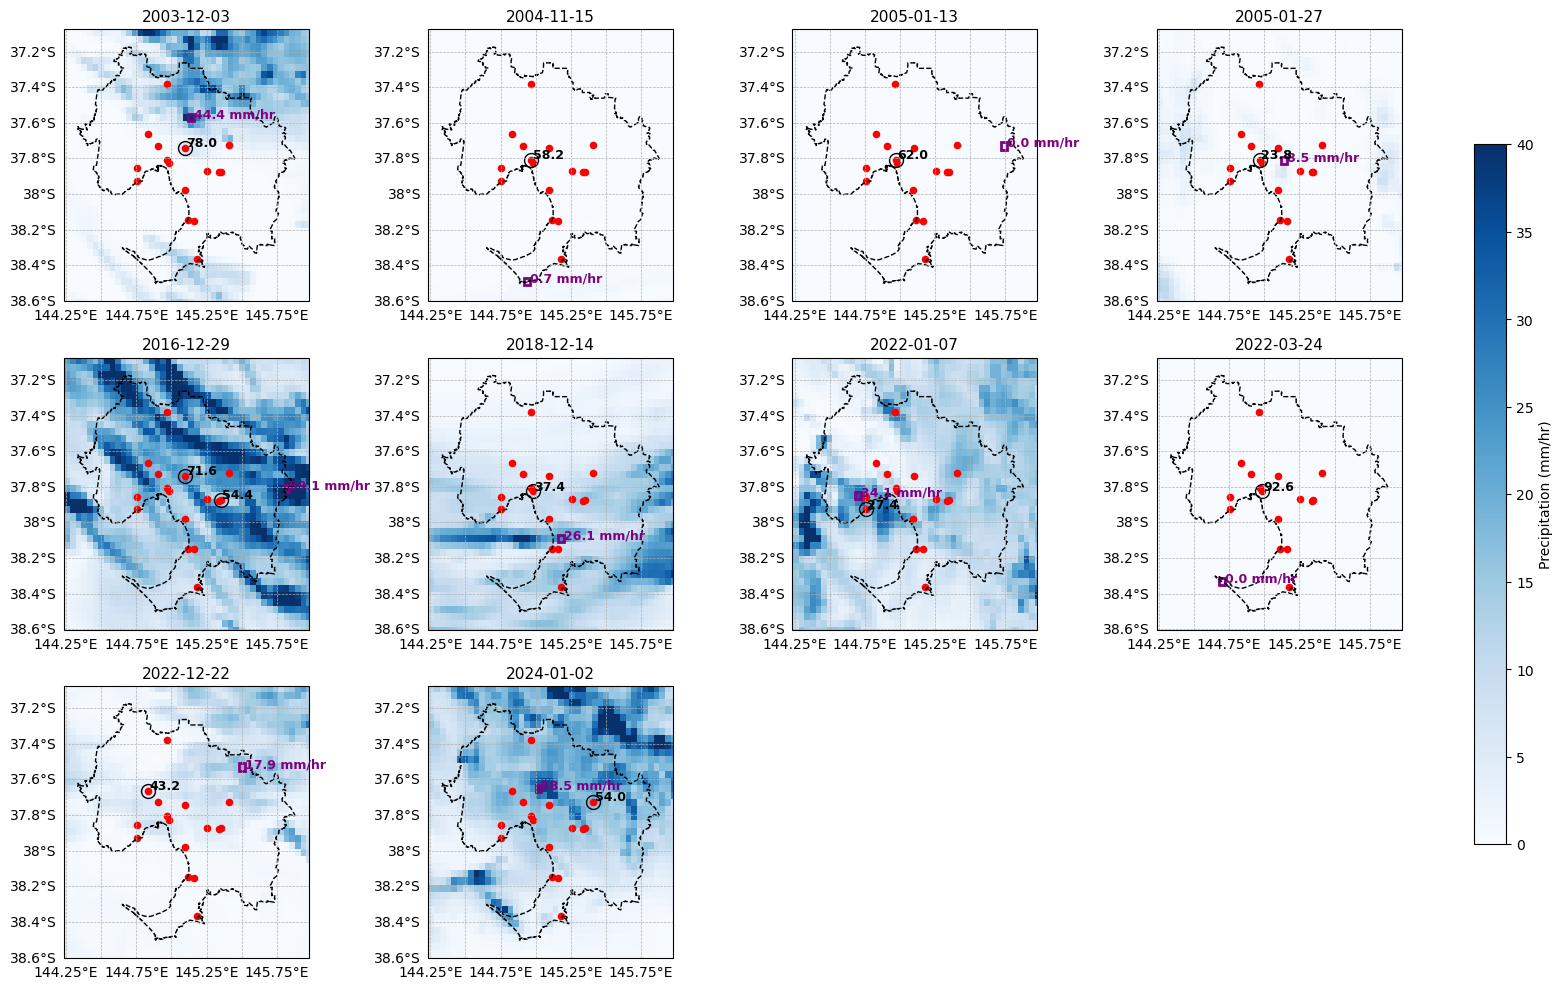

In [5]:
# --- File paths, melbourne --
base_path = "/g/data/w28/yk8692/nesp"
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004"
summary_file = f"{base_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"
stations_file = f"{base_path}/station/All_stations_information.xlsx"
shp_path = f"{base_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"

# --- Load Top 10 Summary and extract dates ---
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
df['date'] = df['Datetime_10min_Max'].dt.date
dates = sorted(df['date'].unique())
print("Top event dates:", dates)

# --- Load shapefile and stations ---
gccsa = gpd.read_file(shp_path)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)].to_crs(epsg=4326)
minx, miny, maxx, maxy = mel_shp.total_bounds

stations = pd.read_excel(stations_file)
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude), crs="EPSG:4326")
stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]

# Use a reference file to create mesh grid
ds_ref = xr.open_dataset(f"{barra_path}/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc")
lon, lat = ds_ref['lon'].values, ds_ref['lat'].values
lon2d, lat2d = np.meshgrid(lon, lat)
ds_ref.close()

mask = contains(mel_shp.unary_union, lon2d, lat2d)
lon_res, lat_res = np.mean(np.diff(lon)), np.mean(np.diff(lat))

# --- Create subplots ---
ncols = 4
nrows = int(np.ceil(len(dates) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, date in enumerate(dates):
    ax = axes[idx]
    year, month = date.year, date.month
    ncname = f"pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{year}{month:02d}-{year}{month:02d}.nc"
    ds = xr.open_dataset(os.path.join(barra_path, ncname))
    ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
    ds_day = ds.sel(time=str(date))
    daily_max = ds_day['pr'].max(dim='time') * 3600  # mm/hr
    ds.close()

    masked = np.where(mask, daily_max.values, np.nan)
    i_max, j_max = np.unravel_index(np.nanargmax(masked), masked.shape)
    max_val, max_lon, max_lat = masked[i_max, j_max], lon2d[i_max, j_max], lat2d[i_max, j_max]

    pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())

    # Boundary and max box
    mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2), lon_res, lat_res,
                                    linewidth=2, edgecolor='purple', facecolor='none', transform=ccrs.PlateCarree()))
    ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.1f} mm/hr', fontsize=9, color='purple', fontweight='bold', transform=ccrs.PlateCarree())

    # AWS stations
    stations_in_region.plot(ax=ax, color='red', markersize=20, transform=ccrs.PlateCarree())

    # Overlay top stations
    top_stations = df[df['date'] == date]
    for _, row in top_stations.iterrows():
        ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=10,
                markerfacecolor='none', markeredgecolor='black', linewidth=2, transform=ccrs.PlateCarree())
        ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01, f"{row['Daily_Max_1h']:.1f}",
                fontsize=9, fontweight='bold', transform=ccrs.PlateCarree())

    ax.set_extent([minx - 0.1, maxx + 0.1, miny - 0.1, maxy + 0.1])
    ax.set_title(str(date), fontsize=11)
    # ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    # Add gridlines and disable top/right labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    
# Turn off unused axes
for ax in axes[len(dates):]:
    ax.set_visible(False)

# Colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Precipitation (mm/hr)')

# plt.suptitle("Daily Max Precipitation from BARRA across Top Event Dates", fontsize=16)
# plt.savefig(f"{base_path}/figure/barra_top10_subplot_separate_day.jpg", dpi=300, bbox_inches='tight')
plt.show()

Top event dates: [datetime.date(2002, 3, 31), datetime.date(2003, 2, 2), datetime.date(2004, 1, 31), datetime.date(2007, 12, 26), datetime.date(2007, 12, 29), datetime.date(2009, 10, 15), datetime.date(2010, 3, 22), datetime.date(2011, 7, 20), datetime.date(2012, 11, 24), datetime.date(2014, 10, 18)]


/jobfs/142020098.gadi-pbs/ipykernel_4084449/1613029771.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]
/jobfs/142020098.gadi-pbs/ipykernel_4084449/1613029771.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = contains(mel_shp.unary_union, lon2d, lat2d)


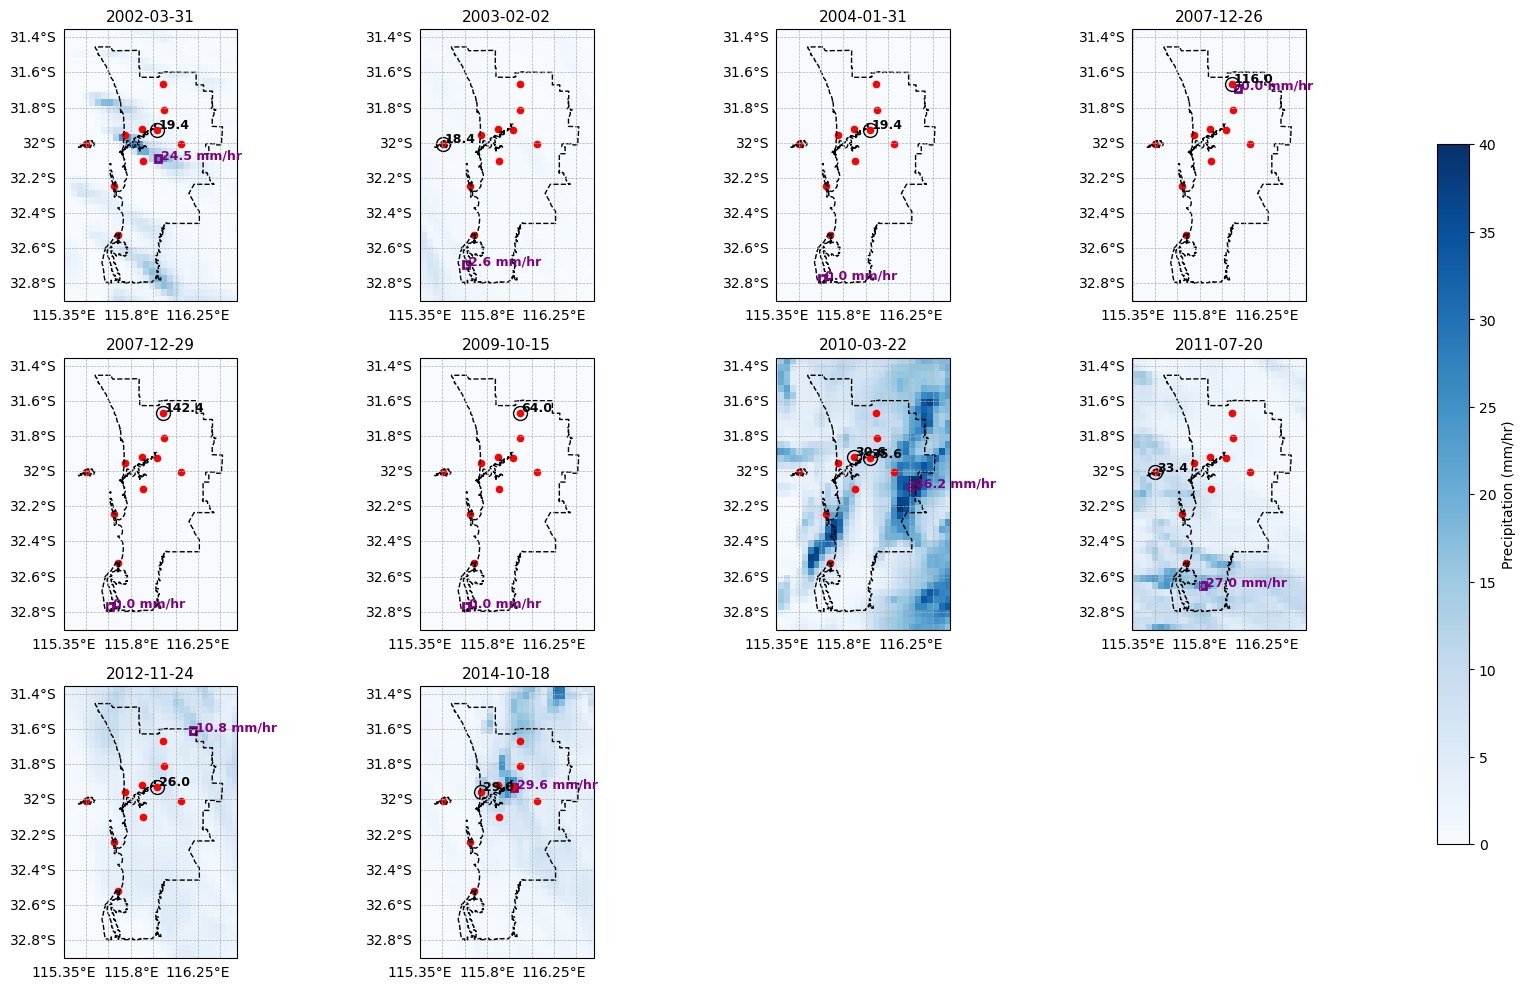

In [4]:
# --- File paths, perth ---
base_path = "/g/data/w28/yk8692/nesp"
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004"
summary_file = f"{base_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"
stations_file = f"{base_path}/station/All_stations_information.xlsx"
shp_path = f"{base_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"

# --- Load Top 10 Summary and extract dates ---
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
df['date'] = df['Datetime_10min_Max'].dt.date
dates = sorted(df['date'].unique())
dates = df.drop_duplicates('date')['date'].tolist()
print("Top event dates:", dates)

# --- Load shapefile and stations ---
gccsa = gpd.read_file(shp_path)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)].to_crs(epsg=4326)
minx, miny, maxx, maxy = mel_shp.total_bounds

stations = pd.read_excel(stations_file)
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude), crs="EPSG:4326")
stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]

# Use a reference file to create mesh grid
ds_ref = xr.open_dataset(f"{barra_path}/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc")
lon, lat = ds_ref['lon'].values, ds_ref['lat'].values
lon2d, lat2d = np.meshgrid(lon, lat)
ds_ref.close()

mask = contains(mel_shp.union_all(), lon2d, lat2d)
lon_res, lat_res = np.mean(np.diff(lon)), np.mean(np.diff(lat))

# --- Create subplots ---
ncols = 4
nrows = int(np.ceil(len(dates) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, date in enumerate(dates):
    ax = axes[idx]
    year, month = date.year, date.month
    ncname = f"pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{year}{month:02d}-{year}{month:02d}.nc"
    ds = xr.open_dataset(os.path.join(barra_path, ncname))
    ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
    ds_day = ds.sel(time=str(date))
    daily_max = ds_day['pr'].max(dim='time') * 3600  # mm/hr
    ds.close()

    masked = np.where(mask, daily_max.values, np.nan)
    i_max, j_max = np.unravel_index(np.nanargmax(masked), masked.shape)
    max_val, max_lon, max_lat = masked[i_max, j_max], lon2d[i_max, j_max], lat2d[i_max, j_max]

    pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())

    # Boundary and max box
    mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2), lon_res, lat_res,
                                    linewidth=2, edgecolor='purple', facecolor='none', transform=ccrs.PlateCarree()))
    ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.1f} mm/hr', fontsize=9, color='purple', fontweight='bold', transform=ccrs.PlateCarree())

    # AWS stations
    stations_in_region.plot(ax=ax, color='red', markersize=20, transform=ccrs.PlateCarree())

    # Overlay top stations
    top_stations = df[df['date'] == date]
    for _, row in top_stations.iterrows():
        ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=10,
                markerfacecolor='none', markeredgecolor='black', linewidth=2, transform=ccrs.PlateCarree())
        ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01, f"{row['Daily_Max_1h']:.1f}",
                fontsize=9, fontweight='bold', transform=ccrs.PlateCarree())

    ax.set_extent([minx - 0.1, maxx + 0.1, miny - 0.1, maxy + 0.1])
    ax.set_title(str(date), fontsize=11)
    # ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    # Add gridlines and disable top/right labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    
# Turn off unused axes
for ax in axes[len(dates):]:
    ax.set_visible(False)

# Colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Precipitation (mm/hr)')

# plt.suptitle("Daily Max Precipitation from BARRA across Top Event Dates", fontsize=16)
plt.savefig(f"{base_path}/figure/{region_name}_barra_top10_subplot_separate_day.jpg", dpi=300, bbox_inches='tight')
plt.show()

Top event dates: [datetime.date(2007, 12, 26), datetime.date(2007, 12, 29), datetime.date(2014, 10, 18), datetime.date(2010, 3, 22), datetime.date(2009, 10, 15), datetime.date(2012, 11, 24), datetime.date(2004, 1, 31), datetime.date(2002, 3, 31), datetime.date(2003, 2, 2), datetime.date(2011, 7, 20)]


/jobfs/142194820.gadi-pbs/ipykernel_2049253/911518178.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]


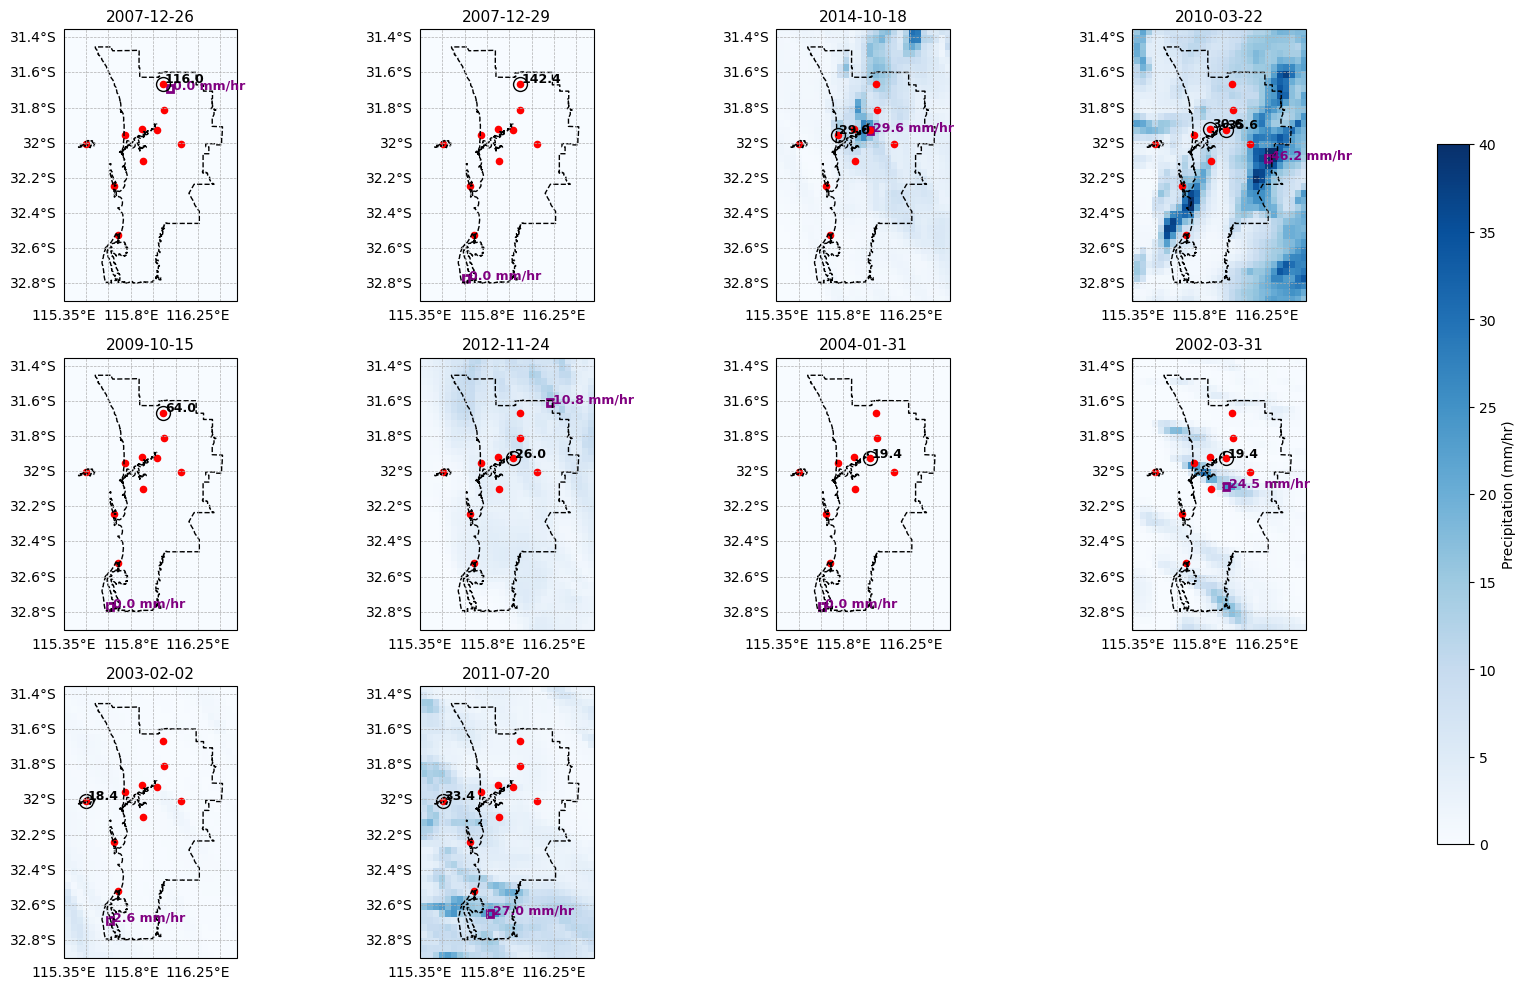

In [4]:
import os
# --- File paths, perth ---
base_path = "/g/data/w28/yk8692/nesp"
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004"
summary_file = f"{base_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"
stations_file = f"{base_path}/station/All_stations_information.xlsx"
shp_path = f"{base_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"

# --- Load Top 10 Summary and extract dates ---
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
df['date'] = df['Datetime_10min_Max'].dt.date
dates = sorted(df['date'].unique())
dates = df.drop_duplicates('date')['date'].tolist()
print("Top event dates:", dates)

# --- Load shapefile and stations ---
gccsa = gpd.read_file(shp_path)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)].to_crs(epsg=4326)
minx, miny, maxx, maxy = mel_shp.total_bounds

stations = pd.read_excel(stations_file)
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude), crs="EPSG:4326")
stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]

# Use a reference file to create mesh grid
ds_ref = xr.open_dataset(f"{barra_path}/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc")
lon, lat = ds_ref['lon'].values, ds_ref['lat'].values
lon2d, lat2d = np.meshgrid(lon, lat)
ds_ref.close()

mask = contains(mel_shp.union_all(), lon2d, lat2d)
lon_res, lat_res = np.mean(np.diff(lon)), np.mean(np.diff(lat))

# --- Create subplots ---
ncols = 4
nrows = int(np.ceil(len(dates) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, date in enumerate(dates):
    ax = axes[idx]
    year, month = date.year, date.month
    ncname = f"pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{year}{month:02d}-{year}{month:02d}.nc"
    ds = xr.open_dataset(os.path.join(barra_path, ncname))
    ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
    ds_day = ds.sel(time=str(date))
    daily_max = ds_day['pr'].max(dim='time') * 3600  # mm/hr
    ds.close()

    masked = np.where(mask, daily_max.values, np.nan)
    i_max, j_max = np.unravel_index(np.nanargmax(masked), masked.shape)
    max_val, max_lon, max_lat = masked[i_max, j_max], lon2d[i_max, j_max], lat2d[i_max, j_max]

    pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())

    # Boundary and max box
    mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2), lon_res, lat_res,
                                    linewidth=2, edgecolor='purple', facecolor='none', transform=ccrs.PlateCarree()))
    ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.1f} mm/hr', fontsize=9, color='purple', fontweight='bold', transform=ccrs.PlateCarree())

    # AWS stations
    stations_in_region.plot(ax=ax, color='red', markersize=20, transform=ccrs.PlateCarree())

    # Overlay top stations
    top_stations = df[df['date'] == date]
    for _, row in top_stations.iterrows():
        ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=10,
                markerfacecolor='none', markeredgecolor='black', linewidth=2, transform=ccrs.PlateCarree())
        ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01, f"{row['Daily_Max_1h']:.1f}",
                fontsize=9, fontweight='bold', transform=ccrs.PlateCarree())

    ax.set_extent([minx - 0.1, maxx + 0.1, miny - 0.1, maxy + 0.1])
    ax.set_title(str(date), fontsize=11)
    # ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    # Add gridlines and disable top/right labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    
# Turn off unused axes
for ax in axes[len(dates):]:
    ax.set_visible(False)

# Colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Precipitation (mm/hr)')

# plt.suptitle("Daily Max Precipitation from BARRA across Top Event Dates", fontsize=16)
plt.savefig(f"{base_path}/figure/{region_name}_barra_top10_subplot_separate_day_reorder.jpg", dpi=300, bbox_inches='tight')
plt.show()

Top event dates: [datetime.date(2013, 1, 26), datetime.date(2013, 11, 21), datetime.date(2023, 2, 21), datetime.date(2024, 1, 13), datetime.date(2019, 1, 22), datetime.date(2011, 2, 4), datetime.date(2020, 2, 15), datetime.date(2011, 12, 11), datetime.date(2003, 3, 14), datetime.date(2014, 2, 19)]


/jobfs/145080338.gadi-pbs/ipykernel_2938430/4051203612.py:49: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]


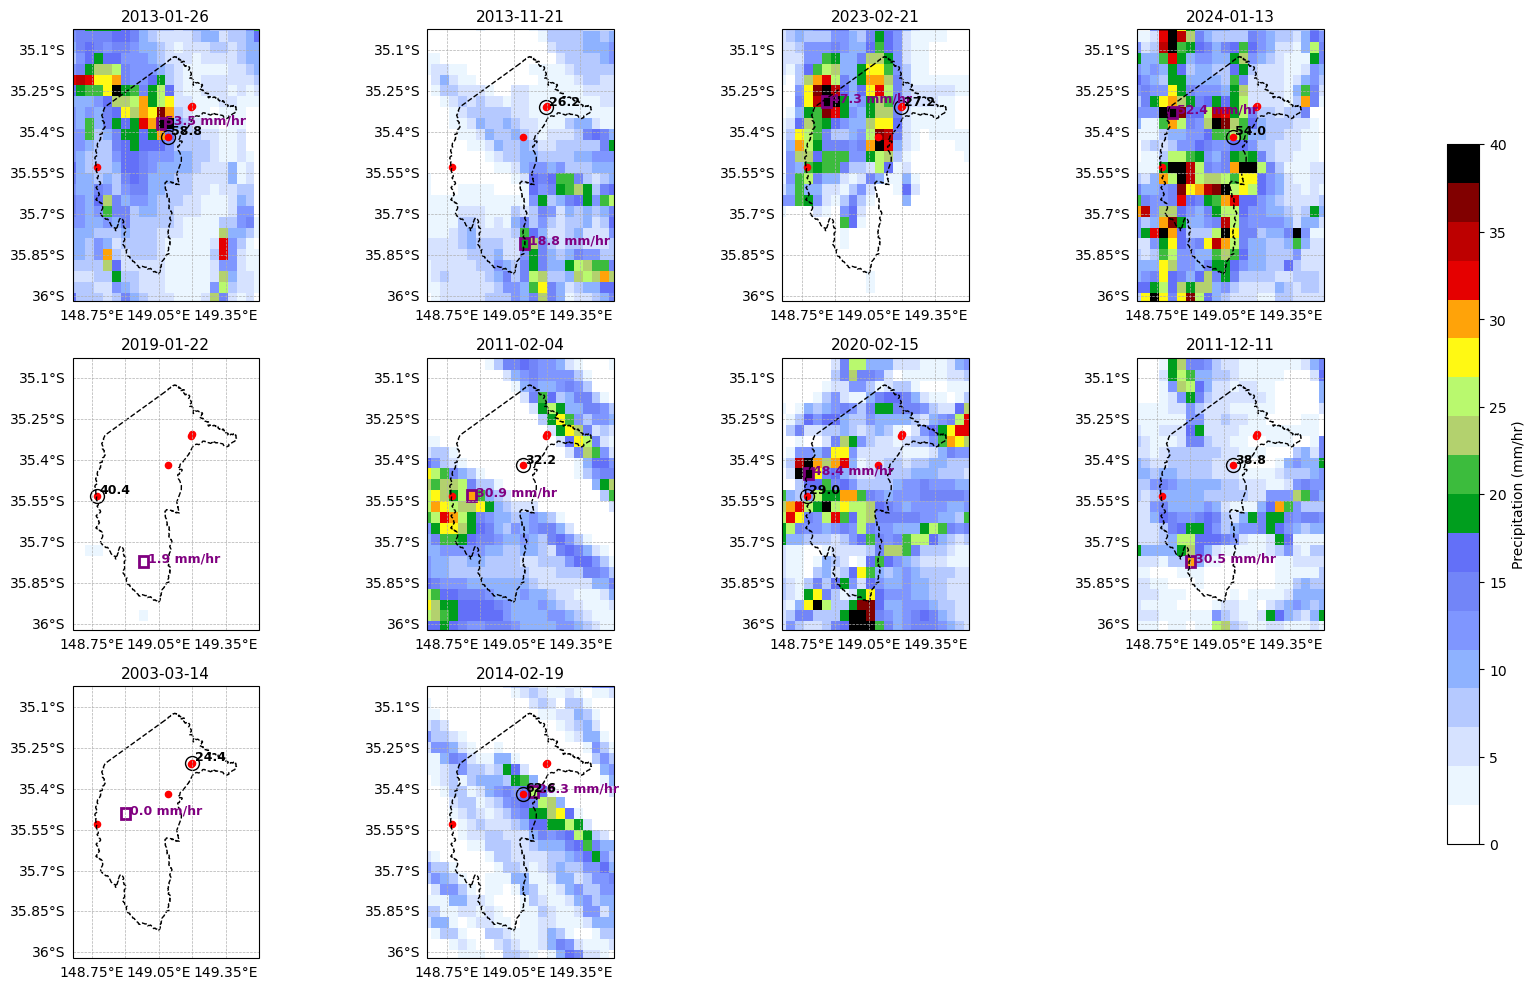

In [6]:
import os
from matplotlib.colors import ListedColormap
# --- File paths ---
base_path = "/g/data/w28/yk8692/nesp"
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20250528"
summary_file = f"{base_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"
stations_file = f"{base_path}/station/All_stations_information.xlsx"
shp_path = f"{base_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"

# Define your RGB colors
rgb_colors = np.array([
    [255, 255, 255],
    [235, 246, 255],
    [214, 226, 255],
    [181, 201, 255],
    [142, 178, 255],
    [127, 150, 255],
    [114, 133, 248],
    [99, 112, 248],
    [0, 158, 30],
    [60, 188, 61],
    [179, 209, 110],
    [185, 249, 110],
    [255, 249, 19],
    [255, 163, 9],
    [229, 0, 0],
    [189, 0, 0],
    [129, 0, 0],
    [0, 0, 0],
]) / 255.0  # Normalise to [0, 1]

# Create the colormap
custom_cmap = ListedColormap(rgb_colors, name='custom_precip_cmap')

# --- Load Top 10 Summary and extract dates ---
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
df['date'] = df['Datetime_10min_Max'].dt.date
dates = sorted(df['date'].unique())
dates = df.drop_duplicates('date')['date'].tolist()
print("Top event dates:", dates)

# --- Load shapefile and stations ---
gccsa = gpd.read_file(shp_path)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)].to_crs(epsg=4326)
minx, miny, maxx, maxy = mel_shp.total_bounds

stations = pd.read_excel(stations_file)
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude), crs="EPSG:4326")
stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]

# Use a reference file to create mesh grid
ds_ref = xr.open_dataset(f"{barra_path}/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc")
lon, lat = ds_ref['lon'].values, ds_ref['lat'].values
lon2d, lat2d = np.meshgrid(lon, lat)
ds_ref.close()

mask = contains(mel_shp.union_all(), lon2d, lat2d)
lon_res, lat_res = np.mean(np.diff(lon)), np.mean(np.diff(lat))

# --- Create subplots ---
ncols = 4
nrows = int(np.ceil(len(dates) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, date in enumerate(dates):
    ax = axes[idx]
    year, month = date.year, date.month
    ncname = f"pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{year}{month:02d}-{year}{month:02d}.nc"
    ds = xr.open_dataset(os.path.join(barra_path, ncname))
    ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
    ds_day = ds.sel(time=str(date))
    daily_max = ds_day['pr'].max(dim='time') * 3600  # mm/hr
    ds.close()

    masked = np.where(mask, daily_max.values, np.nan)
    i_max, j_max = np.unravel_index(np.nanargmax(masked), masked.shape)
    max_val, max_lon, max_lat = masked[i_max, j_max], lon2d[i_max, j_max], lat2d[i_max, j_max]

    # pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())
    pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap=custom_cmap, vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())

    # Boundary and max box
    mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2), lon_res, lat_res,
                                    linewidth=2, edgecolor='purple', facecolor='none', transform=ccrs.PlateCarree()))
    ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.1f} mm/hr', fontsize=9, color='purple', fontweight='bold', transform=ccrs.PlateCarree())

    # AWS stations
    stations_in_region.plot(ax=ax, color='red', markersize=20, transform=ccrs.PlateCarree())

    # Overlay top stations
    top_stations = df[df['date'] == date]
    for _, row in top_stations.iterrows():
        ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=10,
                markerfacecolor='none', markeredgecolor='black', linewidth=2, transform=ccrs.PlateCarree())
        ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01, f"{row['Daily_Max_1h']:.1f}",
                fontsize=9, fontweight='bold', transform=ccrs.PlateCarree())

    ax.set_extent([minx - 0.1, maxx + 0.1, miny - 0.1, maxy + 0.1])
    ax.set_title(str(date), fontsize=11)
    # ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    # Add gridlines and disable top/right labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    
# Turn off unused axes
for ax in axes[len(dates):]:
    ax.set_visible(False)

# Colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Precipitation (mm/hr)')

# plt.suptitle("Daily Max Precipitation from BARRA across Top Event Dates", fontsize=16)
plt.savefig(f"{base_path}/figure/{region_name}_barra_top10_subplot_separate_day_reorder.jpg", dpi=300, bbox_inches='tight')
plt.show()

Top event dates: [datetime.date(2007, 12, 26), datetime.date(2007, 12, 29), datetime.date(2014, 10, 18), datetime.date(2010, 3, 22), datetime.date(2009, 10, 15), datetime.date(2012, 11, 24), datetime.date(2004, 1, 31), datetime.date(2002, 3, 31), datetime.date(2003, 2, 2), datetime.date(2011, 7, 20)]


/jobfs/142455207.gadi-pbs/ipykernel_3889728/3043155130.py:49: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]


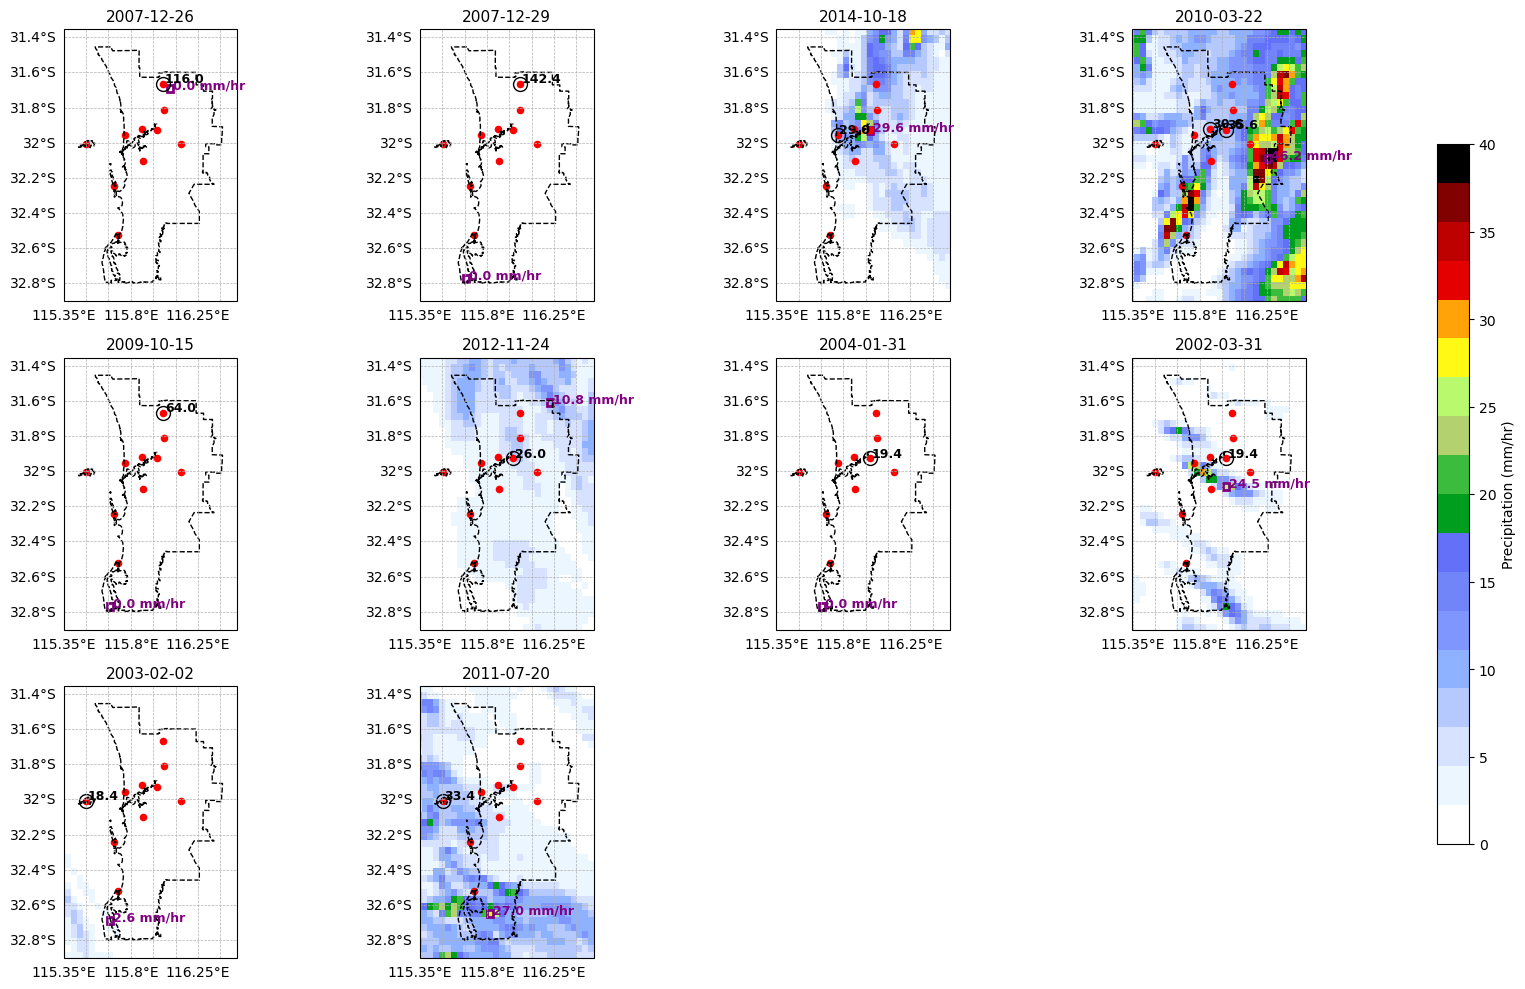

In [3]:
import os
from matplotlib.colors import ListedColormap
# --- File paths, perth ---
base_path = "/g/data/w28/yk8692/nesp"
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004"
summary_file = f"{base_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"
stations_file = f"{base_path}/station/All_stations_information.xlsx"
shp_path = f"{base_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"

# Define your RGB colors
rgb_colors = np.array([
    [255, 255, 255],
    [235, 246, 255],
    [214, 226, 255],
    [181, 201, 255],
    [142, 178, 255],
    [127, 150, 255],
    [114, 133, 248],
    [99, 112, 248],
    [0, 158, 30],
    [60, 188, 61],
    [179, 209, 110],
    [185, 249, 110],
    [255, 249, 19],
    [255, 163, 9],
    [229, 0, 0],
    [189, 0, 0],
    [129, 0, 0],
    [0, 0, 0],
]) / 255.0  # Normalise to [0, 1]

# Create the colormap
custom_cmap = ListedColormap(rgb_colors, name='custom_precip_cmap')

# --- Load Top 10 Summary and extract dates ---
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
df['date'] = df['Datetime_10min_Max'].dt.date
dates = sorted(df['date'].unique())
dates = df.drop_duplicates('date')['date'].tolist()
print("Top event dates:", dates)

# --- Load shapefile and stations ---
gccsa = gpd.read_file(shp_path)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)].to_crs(epsg=4326)
minx, miny, maxx, maxy = mel_shp.total_bounds

stations = pd.read_excel(stations_file)
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude), crs="EPSG:4326")
stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]

# Use a reference file to create mesh grid
ds_ref = xr.open_dataset(f"{barra_path}/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc")
lon, lat = ds_ref['lon'].values, ds_ref['lat'].values
lon2d, lat2d = np.meshgrid(lon, lat)
ds_ref.close()

mask = contains(mel_shp.union_all(), lon2d, lat2d)
lon_res, lat_res = np.mean(np.diff(lon)), np.mean(np.diff(lat))

# --- Create subplots ---
ncols = 4
nrows = int(np.ceil(len(dates) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, date in enumerate(dates):
    ax = axes[idx]
    year, month = date.year, date.month
    ncname = f"pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{year}{month:02d}-{year}{month:02d}.nc"
    ds = xr.open_dataset(os.path.join(barra_path, ncname))
    ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
    ds_day = ds.sel(time=str(date))
    daily_max = ds_day['pr'].max(dim='time') * 3600  # mm/hr
    ds.close()

    masked = np.where(mask, daily_max.values, np.nan)
    i_max, j_max = np.unravel_index(np.nanargmax(masked), masked.shape)
    max_val, max_lon, max_lat = masked[i_max, j_max], lon2d[i_max, j_max], lat2d[i_max, j_max]

    # pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())
    pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap=custom_cmap, vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())

    # Boundary and max box
    mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2), lon_res, lat_res,
                                    linewidth=2, edgecolor='purple', facecolor='none', transform=ccrs.PlateCarree()))
    ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.1f} mm/hr', fontsize=9, color='purple', fontweight='bold', transform=ccrs.PlateCarree())

    # AWS stations
    stations_in_region.plot(ax=ax, color='red', markersize=20, transform=ccrs.PlateCarree())

    # Overlay top stations
    top_stations = df[df['date'] == date]
    for _, row in top_stations.iterrows():
        ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=10,
                markerfacecolor='none', markeredgecolor='black', linewidth=2, transform=ccrs.PlateCarree())
        ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01, f"{row['Daily_Max_1h']:.1f}",
                fontsize=9, fontweight='bold', transform=ccrs.PlateCarree())

    ax.set_extent([minx - 0.1, maxx + 0.1, miny - 0.1, maxy + 0.1])
    ax.set_title(str(date), fontsize=11)
    # ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    # Add gridlines and disable top/right labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    
# Turn off unused axes
for ax in axes[len(dates):]:
    ax.set_visible(False)

# Colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Precipitation (mm/hr)')

# plt.suptitle("Daily Max Precipitation from BARRA across Top Event Dates", fontsize=16)
plt.savefig(f"{base_path}/figure/{region_name}_barra_top10_subplot_separate_day_reorder.jpg", dpi=300, bbox_inches='tight')
plt.show()

Top event dates: [datetime.date(2013, 10, 30), datetime.date(2001, 2, 7), datetime.date(2014, 11, 27), datetime.date(2009, 11, 4), datetime.date(2014, 11, 19), datetime.date(2010, 2, 16), datetime.date(2002, 12, 10), datetime.date(2012, 11, 18), datetime.date(2022, 2, 27), datetime.date(2021, 1, 18)]


/jobfs/142488297.gadi-pbs/ipykernel_2161231/3043155130.py:49: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]


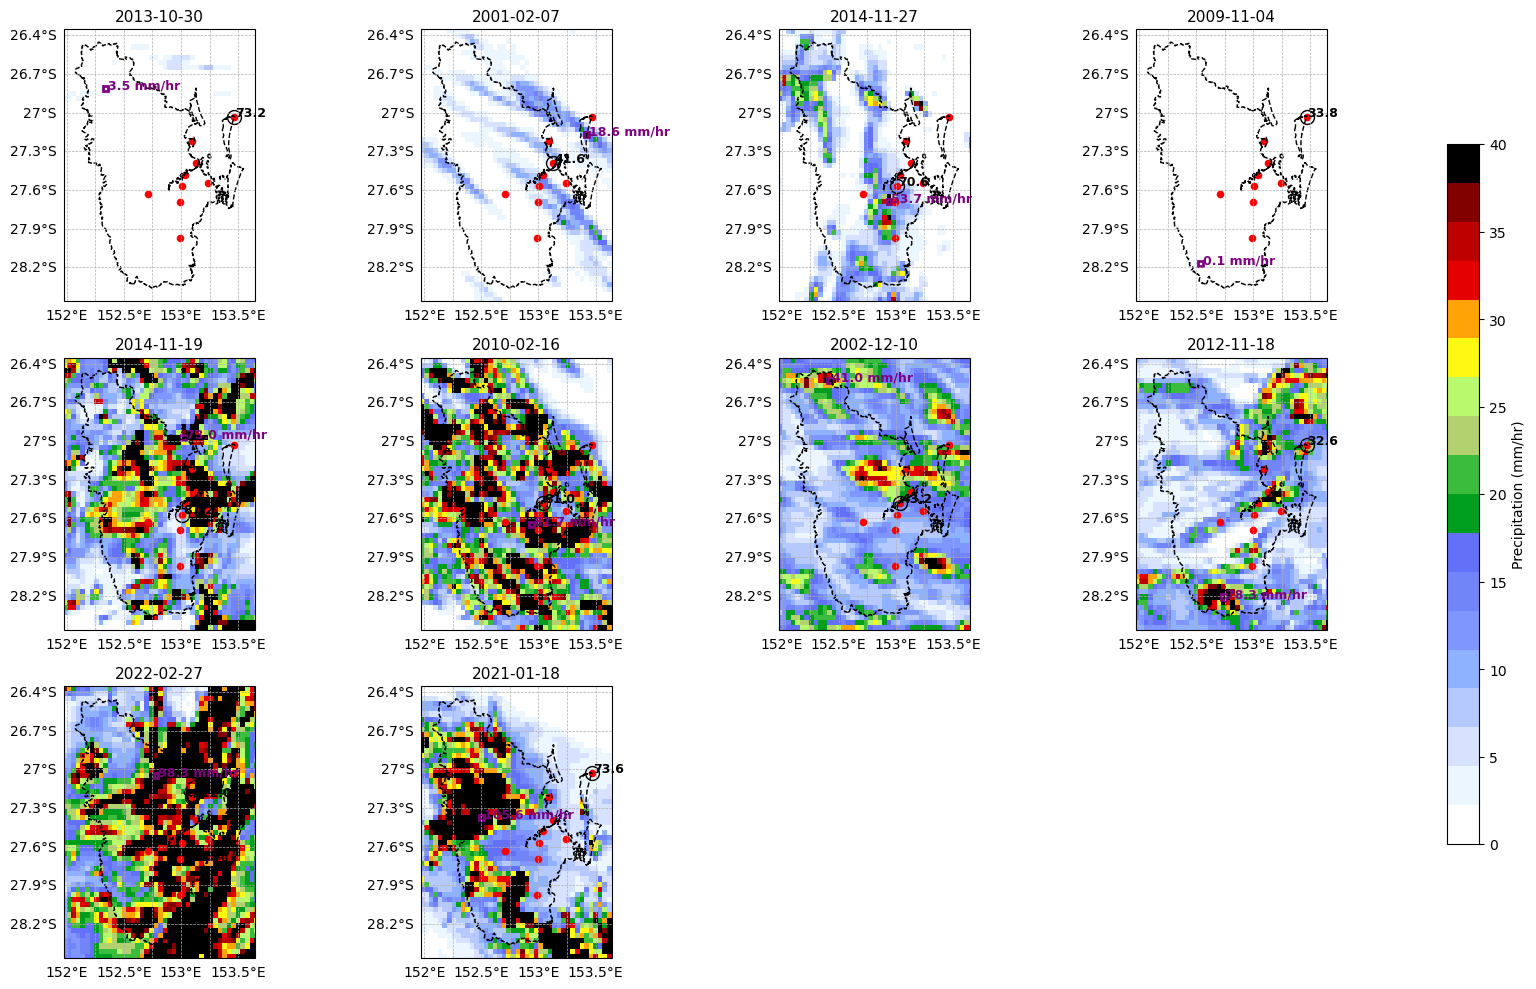

In [3]:
import os
from matplotlib.colors import ListedColormap
# --- File paths, perth ---
base_path = "/g/data/w28/yk8692/nesp"
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004"
summary_file = f"{base_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"
stations_file = f"{base_path}/station/All_stations_information.xlsx"
shp_path = f"{base_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"

# Define your RGB colors
rgb_colors = np.array([
    [255, 255, 255],
    [235, 246, 255],
    [214, 226, 255],
    [181, 201, 255],
    [142, 178, 255],
    [127, 150, 255],
    [114, 133, 248],
    [99, 112, 248],
    [0, 158, 30],
    [60, 188, 61],
    [179, 209, 110],
    [185, 249, 110],
    [255, 249, 19],
    [255, 163, 9],
    [229, 0, 0],
    [189, 0, 0],
    [129, 0, 0],
    [0, 0, 0],
]) / 255.0  # Normalise to [0, 1]

# Create the colormap
custom_cmap = ListedColormap(rgb_colors, name='custom_precip_cmap')

# --- Load Top 10 Summary and extract dates ---
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
df['date'] = df['Datetime_10min_Max'].dt.date
dates = sorted(df['date'].unique())
dates = df.drop_duplicates('date')['date'].tolist()
print("Top event dates:", dates)

# --- Load shapefile and stations ---
gccsa = gpd.read_file(shp_path)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)].to_crs(epsg=4326)
minx, miny, maxx, maxy = mel_shp.total_bounds

stations = pd.read_excel(stations_file)
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude), crs="EPSG:4326")
stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]

# Use a reference file to create mesh grid
ds_ref = xr.open_dataset(f"{barra_path}/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc")
lon, lat = ds_ref['lon'].values, ds_ref['lat'].values
lon2d, lat2d = np.meshgrid(lon, lat)
ds_ref.close()

mask = contains(mel_shp.union_all(), lon2d, lat2d)
lon_res, lat_res = np.mean(np.diff(lon)), np.mean(np.diff(lat))

# --- Create subplots ---
ncols = 4
nrows = int(np.ceil(len(dates) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, date in enumerate(dates):
    ax = axes[idx]
    year, month = date.year, date.month
    ncname = f"pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{year}{month:02d}-{year}{month:02d}.nc"
    ds = xr.open_dataset(os.path.join(barra_path, ncname))
    ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
    ds_day = ds.sel(time=str(date))
    daily_max = ds_day['pr'].max(dim='time') * 3600  # mm/hr
    ds.close()

    masked = np.where(mask, daily_max.values, np.nan)
    i_max, j_max = np.unravel_index(np.nanargmax(masked), masked.shape)
    max_val, max_lon, max_lat = masked[i_max, j_max], lon2d[i_max, j_max], lat2d[i_max, j_max]

    # pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())
    pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap=custom_cmap, vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())

    # Boundary and max box
    mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2), lon_res, lat_res,
                                    linewidth=2, edgecolor='purple', facecolor='none', transform=ccrs.PlateCarree()))
    ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.1f} mm/hr', fontsize=9, color='purple', fontweight='bold', transform=ccrs.PlateCarree())

    # AWS stations
    stations_in_region.plot(ax=ax, color='red', markersize=20, transform=ccrs.PlateCarree())

    # Overlay top stations
    top_stations = df[df['date'] == date]
    for _, row in top_stations.iterrows():
        ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=10,
                markerfacecolor='none', markeredgecolor='black', linewidth=2, transform=ccrs.PlateCarree())
        ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01, f"{row['Daily_Max_1h']:.1f}",
                fontsize=9, fontweight='bold', transform=ccrs.PlateCarree())

    ax.set_extent([minx - 0.1, maxx + 0.1, miny - 0.1, maxy + 0.1])
    ax.set_title(str(date), fontsize=11)
    # ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    # Add gridlines and disable top/right labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    
# Turn off unused axes
for ax in axes[len(dates):]:
    ax.set_visible(False)

# Colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Precipitation (mm/hr)')

# plt.suptitle("Daily Max Precipitation from BARRA across Top Event Dates", fontsize=16)
plt.savefig(f"{base_path}/figure/{region_name}_barra_top10_subplot_separate_day_reorder.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
print(str(barra_path[0]))

/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20250528


Top event dates: [datetime.date(2005, 10, 2), datetime.date(2016, 1, 29), datetime.date(2015, 8, 24), datetime.date(2023, 12, 2), datetime.date(2007, 3, 1), datetime.date(2014, 4, 14), datetime.date(2010, 12, 16), datetime.date(2019, 3, 14), datetime.date(2018, 10, 17), datetime.date(2018, 12, 19)]


/jobfs/144686508.gadi-pbs/ipykernel_3052087/2863014092.py:52: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]


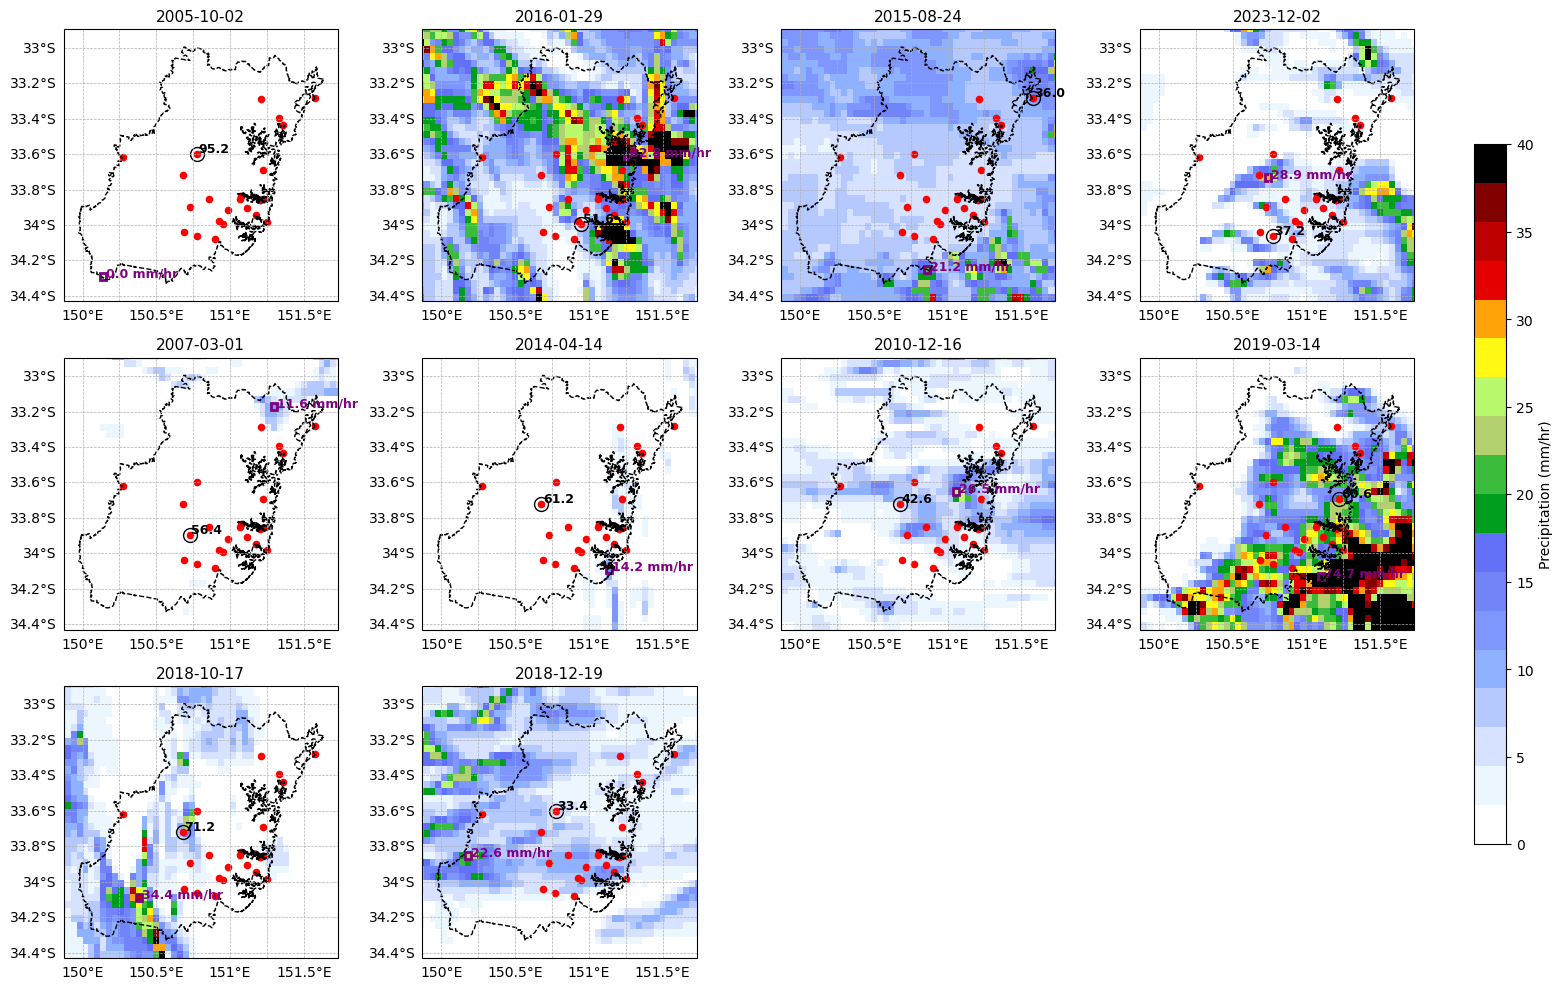

In [13]:
import os
import glob
from matplotlib.colors import ListedColormap
# --- File paths, perth ---
base_path = "/g/data/w28/yk8692/nesp"
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20250528"
region_name = 'Sydney'  # Change this to any target region name

summary_file = f"{base_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"
stations_file = f"{base_path}/station/All_stations_information.xlsx"
shp_path = f"{base_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"

# Define your RGB colors
rgb_colors = np.array([
    [255, 255, 255],
    [235, 246, 255],
    [214, 226, 255],
    [181, 201, 255],
    [142, 178, 255],
    [127, 150, 255],
    [114, 133, 248],
    [99, 112, 248],
    [0, 158, 30],
    [60, 188, 61],
    [179, 209, 110],
    [185, 249, 110],
    [255, 249, 19],
    [255, 163, 9],
    [229, 0, 0],
    [189, 0, 0],
    [129, 0, 0],
    [0, 0, 0],
]) / 255.0  # Normalise to [0, 1]

# Create the colormap
custom_cmap = ListedColormap(rgb_colors, name='custom_precip_cmap')

# --- Load Top 10 Summary and extract dates ---
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
df['date'] = df['Datetime_10min_Max'].dt.date
dates = sorted(df['date'].unique())
dates = df.drop_duplicates('date')['date'].tolist()
print("Top event dates:", dates)

# --- Load shapefile and stations ---
gccsa = gpd.read_file(shp_path)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)].to_crs(epsg=4326)
minx, miny, maxx, maxy = mel_shp.total_bounds

stations = pd.read_excel(stations_file)
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude), crs="EPSG:4326")
stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]

# Use a reference file to create mesh grid
ds_ref = xr.open_dataset(f"{barra_path}/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc")
lon, lat = ds_ref['lon'].values, ds_ref['lat'].values
lon2d, lat2d = np.meshgrid(lon, lat)
ds_ref.close()

mask = contains(mel_shp.union_all(), lon2d, lat2d)
lon_res, lat_res = np.mean(np.diff(lon)), np.mean(np.diff(lat))

# --- Create subplots ---
ncols = 4
nrows = int(np.ceil(len(dates) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, date in enumerate(dates):
    ax = axes[idx]
    year, month = date.year, date.month
    ncname = f"pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{year}{month:02d}-{year}{month:02d}.nc"
    ds = xr.open_dataset(os.path.join(barra_path, ncname))
    ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
    ds_day = ds.sel(time=str(date))
    daily_max = ds_day['pr'].max(dim='time') * 3600  # mm/hr
    ds.close()

    masked = np.where(mask, daily_max.values, np.nan)
    i_max, j_max = np.unravel_index(np.nanargmax(masked), masked.shape)
    max_val, max_lon, max_lat = masked[i_max, j_max], lon2d[i_max, j_max], lat2d[i_max, j_max]

    # pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())
    pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap=custom_cmap, vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())

    # Boundary and max box
    mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2), lon_res, lat_res,
                                    linewidth=2, edgecolor='purple', facecolor='none', transform=ccrs.PlateCarree()))
    ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.1f} mm/hr', fontsize=9, color='purple', fontweight='bold', transform=ccrs.PlateCarree())

    # AWS stations
    stations_in_region.plot(ax=ax, color='red', markersize=20, transform=ccrs.PlateCarree())

    # Overlay top stations
    top_stations = df[df['date'] == date]
    for _, row in top_stations.iterrows():
        ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=10,
                markerfacecolor='none', markeredgecolor='black', linewidth=2, transform=ccrs.PlateCarree())
        ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01, f"{row['Daily_Max_1h']:.1f}",
                fontsize=9, fontweight='bold', transform=ccrs.PlateCarree())

    ax.set_extent([minx - 0.1, maxx + 0.1, miny - 0.1, maxy + 0.1])
    ax.set_title(str(date), fontsize=11)
    # ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    # Add gridlines and disable top/right labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    
# Turn off unused axes
for ax in axes[len(dates):]:
    ax.set_visible(False)

# Colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Precipitation (mm/hr)')

# plt.suptitle("Daily Max Precipitation from BARRA across Top Event Dates", fontsize=16)
plt.savefig(f"{base_path}/figure/{region_name}_barra_top10_subplot_separate_day_reorder.jpg", dpi=300, bbox_inches='tight')
plt.show()

Top event dates: [datetime.date(2013, 12, 28), datetime.date(2013, 10, 10), datetime.date(2014, 4, 1), datetime.date(2010, 3, 25), datetime.date(2004, 7, 1), datetime.date(2016, 4, 1), datetime.date(2018, 5, 10), datetime.date(2004, 8, 12), datetime.date(2011, 12, 19), datetime.date(2021, 12, 2)]


/jobfs/144745780.gadi-pbs/ipykernel_1379874/4280077222.py:52: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]


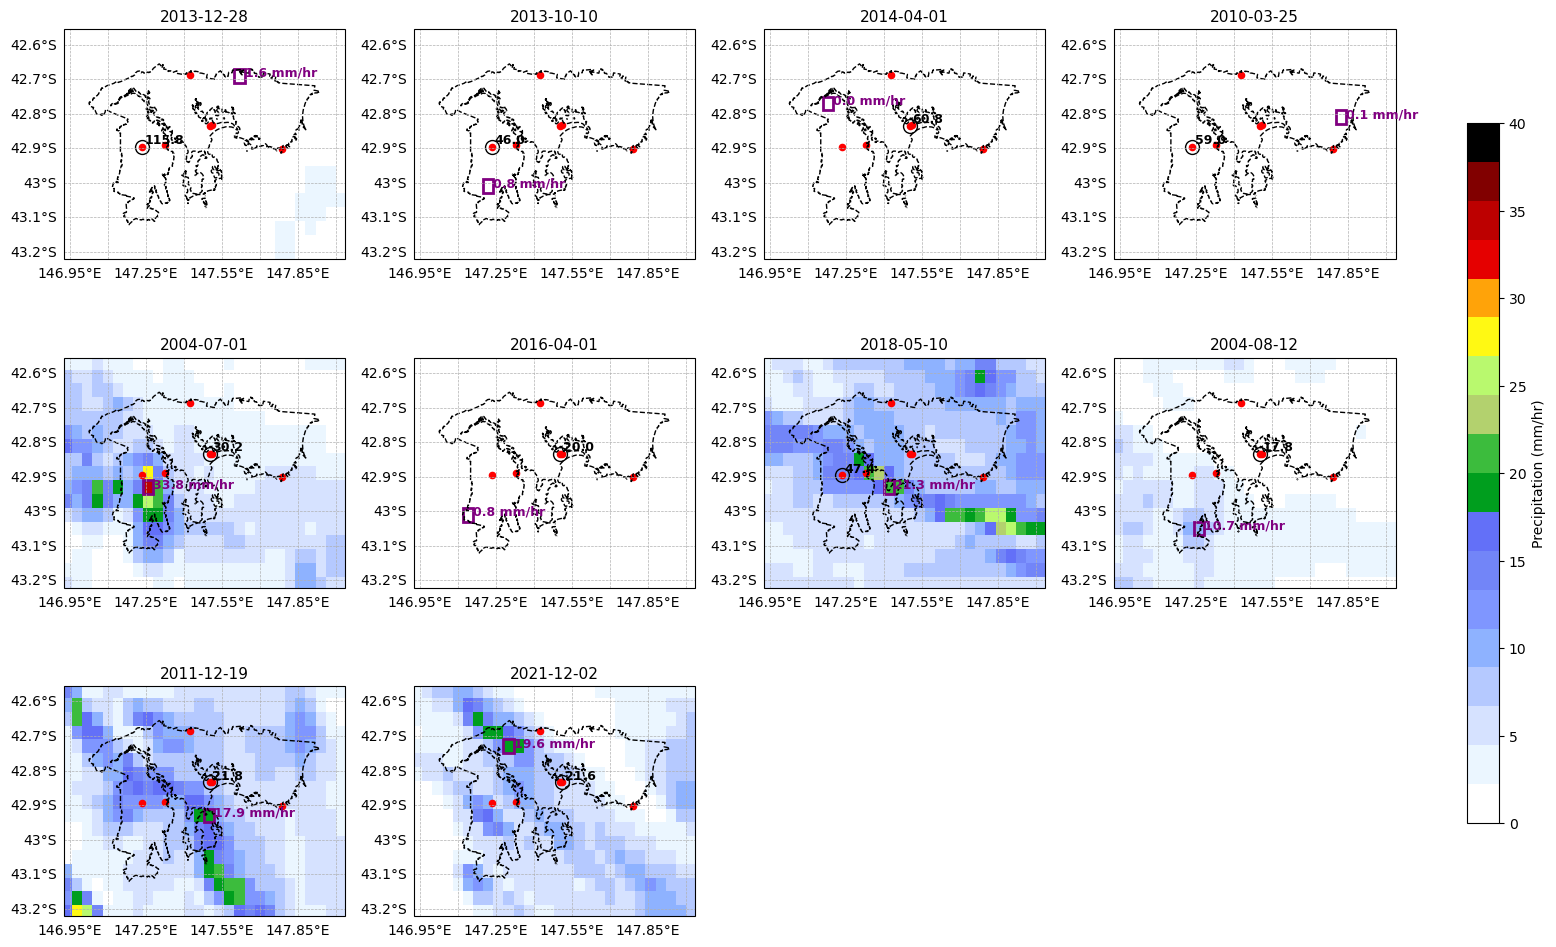

In [3]:
import os
import glob
from matplotlib.colors import ListedColormap
# --- File paths, perth ---
base_path = "/g/data/w28/yk8692/nesp"
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20250528"
region_name = 'Hobart'  # Change this to any target region name

summary_file = f"{base_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"
stations_file = f"{base_path}/station/All_stations_information.xlsx"
shp_path = f"{base_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"

# Define your RGB colors
rgb_colors = np.array([
    [255, 255, 255],
    [235, 246, 255],
    [214, 226, 255],
    [181, 201, 255],
    [142, 178, 255],
    [127, 150, 255],
    [114, 133, 248],
    [99, 112, 248],
    [0, 158, 30],
    [60, 188, 61],
    [179, 209, 110],
    [185, 249, 110],
    [255, 249, 19],
    [255, 163, 9],
    [229, 0, 0],
    [189, 0, 0],
    [129, 0, 0],
    [0, 0, 0],
]) / 255.0  # Normalise to [0, 1]

# Create the colormap
custom_cmap = ListedColormap(rgb_colors, name='custom_precip_cmap')

# --- Load Top 10 Summary and extract dates ---
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
df['date'] = df['Datetime_10min_Max'].dt.date
dates = sorted(df['date'].unique())
dates = df.drop_duplicates('date')['date'].tolist()
print("Top event dates:", dates)

# --- Load shapefile and stations ---
gccsa = gpd.read_file(shp_path)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)].to_crs(epsg=4326)
minx, miny, maxx, maxy = mel_shp.total_bounds

stations = pd.read_excel(stations_file)
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude), crs="EPSG:4326")
stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]

# Use a reference file to create mesh grid
ds_ref = xr.open_dataset(f"{barra_path}/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc")
lon, lat = ds_ref['lon'].values, ds_ref['lat'].values
lon2d, lat2d = np.meshgrid(lon, lat)
ds_ref.close()

mask = contains(mel_shp.union_all(), lon2d, lat2d)
lon_res, lat_res = np.mean(np.diff(lon)), np.mean(np.diff(lat))

# --- Create subplots ---
ncols = 4
nrows = int(np.ceil(len(dates) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, date in enumerate(dates):
    ax = axes[idx]
    year, month = date.year, date.month
    ncname = f"pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{year}{month:02d}-{year}{month:02d}.nc"
    ds = xr.open_dataset(os.path.join(barra_path, ncname))
    ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
    ds_day = ds.sel(time=str(date))
    daily_max = ds_day['pr'].max(dim='time') * 3600  # mm/hr
    ds.close()

    masked = np.where(mask, daily_max.values, np.nan)
    i_max, j_max = np.unravel_index(np.nanargmax(masked), masked.shape)
    max_val, max_lon, max_lat = masked[i_max, j_max], lon2d[i_max, j_max], lat2d[i_max, j_max]

    # pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())
    pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap=custom_cmap, vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())

    # Boundary and max box
    mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2), lon_res, lat_res,
                                    linewidth=2, edgecolor='purple', facecolor='none', transform=ccrs.PlateCarree()))
    ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.1f} mm/hr', fontsize=9, color='purple', fontweight='bold', transform=ccrs.PlateCarree())

    # AWS stations
    stations_in_region.plot(ax=ax, color='red', markersize=20, transform=ccrs.PlateCarree())

    # Overlay top stations
    top_stations = df[df['date'] == date]
    for _, row in top_stations.iterrows():
        ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=10,
                markerfacecolor='none', markeredgecolor='black', linewidth=2, transform=ccrs.PlateCarree())
        ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01, f"{row['Daily_Max_1h']:.1f}",
                fontsize=9, fontweight='bold', transform=ccrs.PlateCarree())

    ax.set_extent([minx - 0.1, maxx + 0.1, miny - 0.1, maxy + 0.1])
    ax.set_title(str(date), fontsize=11)
    # ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    # Add gridlines and disable top/right labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    
# Turn off unused axes
for ax in axes[len(dates):]:
    ax.set_visible(False)

# Colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Precipitation (mm/hr)')

# plt.suptitle("Daily Max Precipitation from BARRA across Top Event Dates", fontsize=16)
plt.savefig(f"{base_path}/figure/{region_name}_barra_top10_subplot_separate_day_reorder.jpg", dpi=300, bbox_inches='tight')
plt.show()